<a href="https://colab.research.google.com/github/duonghieu7104/Trend-Analysis-Aviation-Industry-US/blob/main/notebook/flight_route_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count, mean, stddev, sum
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit


In [2]:
spark = SparkSession.builder \
    .appName("FlightRouteClassification") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()


In [3]:
import kagglehub
path = kagglehub.dataset_download("bhavikjikadara/us-airline-flight-routes-and-fares-1993-2024")
print(f"Dataset downloaded to: {path}")

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset downloaded to: C:\Users\ADMIN\.cache\kagglehub\datasets\bhavikjikadara\us-airline-flight-routes-and-fares-1993-2024\versions\1


In [4]:
df = (
    spark.read
    .option("header", "true")
    .option("inferSchema", "true")
    .option("quote", '"')           # rất quan trọng: nhận diện text trong ngoặc kép
    .option("escape", '"')          # escape ký tự "
    .option("multiLine", "true")    # xử lý text có xuống dòng
    .option("mode", "PERMISSIVE")   # không drop dòng lỗi
    .option("nullValue", "")
    .option("nanValue", "NaN")
    .option("emptyValue", "")
    .csv(f"{path}/*.csv")
)

In [5]:
df.printSchema()
print(f"\nSố dòng: {df.count()}")
print(f"Số cột: {len(df.columns)}")

root
 |-- tbl: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- citymarketid_1: integer (nullable = true)
 |-- citymarketid_2: integer (nullable = true)
 |-- city1: string (nullable = true)
 |-- city2: string (nullable = true)
 |-- airportid_1: integer (nullable = true)
 |-- airportid_2: integer (nullable = true)
 |-- airport_1: string (nullable = true)
 |-- airport_2: string (nullable = true)
 |-- nsmiles: integer (nullable = true)
 |-- passengers: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- carrier_lg: string (nullable = true)
 |-- large_ms: double (nullable = true)
 |-- fare_lg: double (nullable = true)
 |-- carrier_low: string (nullable = true)
 |-- lf_ms: double (nullable = true)
 |-- fare_low: double (nullable = true)
 |-- Geocoded_City1: string (nullable = true)
 |-- Geocoded_City2: string (nullable = true)
 |-- tbl1apk: string (nullable = true)


Số dòng: 245955
Số cột: 23


In [6]:
df.show(5)

+-------+----+-------+--------------+--------------+--------------------+--------------------+-----------+-----------+---------+---------+-------+----------+------+----------+--------+-------+-----------+------+--------+--------------+--------------+--------------------+
|    tbl|Year|quarter|citymarketid_1|citymarketid_2|               city1|               city2|airportid_1|airportid_2|airport_1|airport_2|nsmiles|passengers|  fare|carrier_lg|large_ms|fare_lg|carrier_low| lf_ms|fare_low|Geocoded_City1|Geocoded_City2|             tbl1apk|
+-------+----+-------+--------------+--------------+--------------------+--------------------+-----------+-----------+---------+---------+-------+----------+------+----------+--------+-------+-----------+------+--------+--------------+--------------+--------------------+
|Table1a|2021|      3|         30135|         33195|Allentown/Bethleh...|Tampa, FL (Metrop...|      10135|      14112|      ABE|      PIE|    970|       180| 81.43|        G4|     1.0|

In [7]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+---+----+-------+--------------+--------------+-----+-----+-----------+-----------+---------+---------+-------+----------+----+----------+--------+-------+-----------+-----+--------+--------------+--------------+-------+
|tbl|Year|quarter|citymarketid_1|citymarketid_2|city1|city2|airportid_1|airportid_2|airport_1|airport_2|nsmiles|passengers|fare|carrier_lg|large_ms|fare_lg|carrier_low|lf_ms|fare_low|Geocoded_City1|Geocoded_City2|tbl1apk|
+---+----+-------+--------------+--------------+-----+-----+-----------+-----------+---------+---------+-------+----------+----+----------+--------+-------+-----------+-----+--------+--------------+--------------+-------+
|  0|   0|      0|             0|             0|    0|    0|          0|          0|        0|        0|      0|         0|   0|      1540|    1540|   1540|       1612| 1612|    1612|         39206|         39206|      0|
+---+----+-------+--------------+--------------+-----+-----+-----------+-----------+---------+---------+-------+

In [8]:
# ==================== 1. DATA CLEANING ====================
# Kiểm tra missing values
print("Giá trị thiếu theo cột:")
from pyspark.sql.functions import col as spark_col, when, sum as spark_sum, lit

# Tổng số dòng
_total = df.count()

# Tính số lượng thiếu cho từng cột bằng một lần quét
missing_row = df.select([
    spark_sum(when(spark_col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns
]).collect()[0]

# Tạo DataFrame hiển thị Missing_Count và Percent
missing_records = []
for c in df.columns:
    miss = int(missing_row[c]) if missing_row[c] is not None else 0
    if miss > 0:
        pct = (miss / _total * 100) if _total > 0 else 0
        missing_records.append((c, miss, float(pct)))

missing_df = spark.createDataFrame(missing_records, ["Column", "Missing_Count", "Percent"]) \
    .orderBy(spark_col("Missing_Count").desc())

if missing_df.count() > 0:
    missing_df.show(truncate=False)
else:
    print("Không có giá trị thiếu nào trong DataFrame!")

Giá trị thiếu theo cột:
+--------------+-------------+------------------+
|Column        |Missing_Count|Percent           |
+--------------+-------------+------------------+
|Geocoded_City1|39206        |15.940314285133459|
|Geocoded_City2|39206        |15.940314285133459|
|fare_low      |1612         |0.6554044439023399|
|carrier_low   |1612         |0.6554044439023399|
|lf_ms         |1612         |0.6554044439023399|
|fare_lg       |1540         |0.626130796283873 |
|large_ms      |1540         |0.626130796283873 |
|carrier_lg    |1540         |0.626130796283873 |
+--------------+-------------+------------------+



In [9]:
# Loại bỏ các hàng có giá trị null trong các cột quan trọng
cols_to_check = [
    "lf_ms", "carrier_low", "fare_low",
    "large_ms", "fare_lg", "carrier_lg"
]

# Loại bỏ các hàng có giá trị null trong các cột này
df_clean = df.dropna(subset=cols_to_check)

print("Số dòng trước khi loại null:", df.count())
print("Số dòng sau khi loại null:", df_clean.count())

# 4 Loại bỏ trùng lặp
initial_count = df_clean.count()
df_clean = df_clean.dropDuplicates()
removed = initial_count - df_clean.count()

# Market share trong [0,100]
for c in ['large_ms', 'lf_ms']:
    if c in df_clean.columns:
        invalid = df_clean.filter((col(c) < 0) | (col(c) > 1)).count()
        print(f"  - {c} không hợp lệ: {invalid}")
        df_clean = df_clean.filter((col(c) >= 0) & (col(c) <= 1))

# passengers & fare > 0
for c in ['passengers', 'fare']:
    if c in df_clean.columns:
        df_clean = df_clean.filter(col(c) > 0)

# 7️ Kết quả
df_clean = df_clean

rows_final = df_clean.count()
cols_final = len(df_clean.columns)
print(f"\n Dữ liệu sau khi làm sạch: ({rows_final}, {cols_final})")

Số dòng trước khi loại null: 245955
Số dòng sau khi loại null: 244343
  - large_ms không hợp lệ: 0
  - lf_ms không hợp lệ: 0

 Dữ liệu sau khi làm sạch: (237985, 23)


In [10]:
# ==================== 2. EXPLORATORY DATA ANALYSIS ====================
from pyspark.sql.types import IntegerType, LongType, FloatType, DoubleType
from pyspark.sql.functions import col, count, mean, stddev, min, max, percentile_approx

print("\n" + "="*80)
print("BƯỚC 2: PHÂN TÍCH KHÁM PHÁ DỮ LIỆU (EDA)")
print("="*80)

# Lấy các cột số
numeric_cols = [field.name for field in df_clean.schema.fields if field.dataType in [IntegerType(), LongType(), FloatType(), DoubleType()]]

# Header đẹp
header = f"{'Column':<20} {'Count':>10} {'Mean':>10} {'Std':>10} {'Min':>10} {'Q1':>10} {'Median':>10} {'Q3':>10} {'Max':>10}"
print("\nThống kê mô tả các biến số:")
print("-" * len(header))
print(header)
print("-" * len(header))

# Thống kê từng cột
for col_name in numeric_cols:
    if col_name in df_clean.columns:
        stats = df_clean.select(
            count(col(col_name)).alias("count"),
            mean(col(col_name)).alias("mean"),
            stddev(col(col_name)).alias("std"),
            min(col(col_name)).alias("min"),
            max(col(col_name)).alias("max"),
            percentile_approx(col(col_name), 0.25).alias("q1"),
            percentile_approx(col(col_name), 0.5).alias("median"),
            percentile_approx(col(col_name), 0.75).alias("q3")
        ).collect()[0]

        print(f"{col_name:<20} "
              f"{stats['count']:>10} "
              f"{stats['mean']:>10.2f} "
              f"{stats['std']:>10.2f} "
              f"{stats['min']:>10} "
              f"{stats['q1']:>10} "
              f"{stats['median']:>10} "
              f"{stats['q3']:>10} "
              f"{stats['max']:>10}")



BƯỚC 2: PHÂN TÍCH KHÁM PHÁ DỮ LIỆU (EDA)

Thống kê mô tả các biến số:
------------------------------------------------------------------------------------------------------------
Column                    Count       Mean        Std        Min         Q1     Median         Q3        Max
------------------------------------------------------------------------------------------------------------
Year                     237985    2008.64       8.66       1993       2001       2009       2016       2024
quarter                  237985       2.48       1.12          1          1          2          3          4
citymarketid_1           237985   31556.83    1094.45      30135      30721      31295      32467      35412
citymarketid_2           237985   32175.24    1232.17      30189      30977      32211      33192      35628
airportid_1              237985   12438.23    1430.69      10135      11193      12266      13487      16440
airportid_2              237985   13239.73    1425.33    

In [11]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, lit, when, round

# BƯỚC 1: TÍNH TOÁN ĐIỂM SỐ TIỀM NĂNG (POTENTIAL SCORE)
print("BƯỚC 1: TÍNH TOÁN ĐIỂM SỐ TIỀM NĂNG")
print("="*50)

# Tạo bản sao dữ liệu để xử lý
df_potential = df_clean

# 1. Chuẩn hóa các chỉ số (0-1 scale)
metrics = ['passengers', 'fare', 'nsmiles', 'large_ms', 'lf_ms']

# Tính toán min và max để chuẩn hóa
min_max_stats = {}
for metric in metrics:
    if metric in df_potential.columns:
        stats = df_potential.select(
            F.min(col(metric)).alias("min_val"),
            F.max(col(metric)).alias("max_val")
        ).collect()[0]
        min_max_stats[metric] = {
            'min': stats['min_val'],
            'max': stats['max_val']
        }

# Chuẩn hóa từng số liệu
for metric in metrics:
    if metric in df_potential.columns and metric in min_max_stats:
        min_val = min_max_stats[metric]['min']
        max_val = min_max_stats[metric]['max']
        if max_val != min_val:
            df_potential = df_potential.withColumn(
                f'{metric}_normalized',
                (col(metric) - lit(min_val)) / (lit(max_val) - lit(min_val))
            )
        else:
            df_potential = df_potential.withColumn(f'{metric}_normalized', lit(0.0))

# 2. Tính điểm số tiềm năng dựa trên trọng số
weights = {
    'passengers_normalized': 0.25,
    'fare_normalized': 0.2,
    'nsmiles_normalized': 0.25,
    'large_ms_normalized': 0.15,
    'lf_ms_normalized': 0.15
}

potential_score_expr = lit(0.0)
for metric, weight in weights.items():
    if metric in df_potential.columns:
        potential_score_expr = potential_score_expr + (col(metric) * weight)

df_potential = df_potential.withColumn('potential_score', potential_score_expr)

# 3. Phân loại theo điểm số tiềm năng
df_potential = df_potential.withColumn(
    'potential_level',
    when(col('potential_score') > 0.4, 'Cao')
    .when(col('potential_score') >= 0.3, 'Trung bình')
    .otherwise('Thấp')
)

# 4. Thống kê phân bố
print("\nPhân bố tiềm năng tuyến bay:")
potential_dist = df_potential.groupBy('potential_level').count().orderBy('potential_level')
potential_dist.show()

# Tính tỷ lệ phần trăm
total_count = df_potential.count()
potential_percentages = df_potential.groupBy('potential_level').count() \
    .withColumn('percentage', round(col('count') / lit(total_count) * 100, 3)) \
    .orderBy('potential_level')

print("\nTỷ lệ phần trăm:")
potential_percentages.show()


BƯỚC 1: TÍNH TOÁN ĐIỂM SỐ TIỀM NĂNG

Phân bố tiềm năng tuyến bay:
+---------------+------+
|potential_level| count|
+---------------+------+
|            Cao| 27047|
|           Thấp|120694|
|     Trung bình| 90244|
+---------------+------+


Tỷ lệ phần trăm:
+---------------+------+----------+
|potential_level| count|percentage|
+---------------+------+----------+
|            Cao| 27047|    11.365|
|           Thấp|120694|    50.715|
|     Trung bình| 90244|     37.92|
+---------------+------+----------+



In [12]:
# 5. Thống kê mô tả theo từng nhóm tiềm năng
print("\nThống kê mô tả theo nhóm tiềm năng:")
potential_stats = df_potential.groupBy('potential_level') \
    .agg(
        round(mean('passengers'), 3).alias('avg_passengers'),
        round(mean('fare'), 3).alias('avg_fare'),
        round(mean('nsmiles'), 3).alias('avg_nsmiles'),
        round(mean('large_ms'), 3).alias('avg_large_ms'),
        round(mean('lf_ms'), 3).alias('avg_lf_ms')
    ).orderBy('potential_level')
potential_stats.show()


Thống kê mô tả theo nhóm tiềm năng:
+---------------+--------------+--------+-----------+------------+---------+
|potential_level|avg_passengers|avg_fare|avg_nsmiles|avg_large_ms|avg_lf_ms|
+---------------+--------------+--------+-----------+------------+---------+
|            Cao|       290.126| 266.536|   1906.513|       0.816|    0.743|
|           Thấp|       329.452| 199.544|     905.14|        0.59|    0.273|
|     Trung bình|       288.611| 225.185|   1355.191|       0.707|    0.571|
+---------------+--------------+--------+-----------+------------+---------+



In [13]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import first, last, col, lit, when

# BƯỚC 2: PHÂN TÍCH XU HƯỚNG TĂNG TRƯỞNG
print("\nBƯỚC 2: PHÂN TÍCH XU HƯỚNG TĂNG TRƯỞNG")
print("=" * 50)

# Tạo cửa sổ phân vùng theo tuyến bay (city1, city2) và sắp xếp theo Year
window_spec = Window.partitionBy('city1', 'city2').orderBy('Year') \
                   .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Tính giá trị đầu và cuối cho mỗi tuyến bay
df_with_growth = df_potential.withColumn(
    'first_passengers', first('passengers').over(window_spec)
).withColumn(
    'last_passengers', last('passengers').over(window_spec)
).withColumn(
    'first_fare', first('fare').over(window_spec)
).withColumn(
    'last_fare', last('fare').over(window_spec)
)

# Tính tỷ lệ tăng trưởng
df_with_growth = df_with_growth.withColumn(
    'passenger_growth',
    when(col('first_passengers') > 0,
         (col('last_passengers') - col('first_passengers')) / col('first_passengers'))
    .otherwise(0)
).withColumn(
    'fare_growth',
    when(col('first_fare') > 0,
         (col('last_fare') - col('first_fare')) / col('first_fare'))
    .otherwise(0)
)

# Tính điểm tăng trưởng kết hợp (hành khách 70%, giá vé 30%)
df_with_growth = df_with_growth.withColumn(
    'growth_trend',
    0.7 * col('passenger_growth') + 0.3 * col('fare_growth')
)

# Tự nhiên hóa xu hướng tăng trưởng (chuẩn hóa 0-1)
growth_stats = df_with_growth.select(
    F.min('growth_trend').alias('min_growth'),
    F.max('growth_trend').alias('max_growth')
).collect()[0]

min_growth = growth_stats['min_growth']
max_growth = growth_stats['max_growth']

if max_growth != min_growth:
    df_with_growth = df_with_growth.withColumn(
        'growth_trend_normalized',
        (col('growth_trend') - lit(min_growth)) / (lit(max_growth) - lit(min_growth))
    )
else:
    df_with_growth = df_with_growth.withColumn('growth_trend_normalized', lit(0.0))

# Cập nhật điểm số tiềm năng với xu hướng tăng trưởng (trọng số 10%)
df_potential = df_with_growth.withColumn(
    'potential_score_enhanced',
    col('potential_score') * 0.9 + col('growth_trend_normalized') * 0.1
)

# Phân loại lại theo điểm số cải tiến
df_potential = df_potential.withColumn(
    'potential_level_enhanced',
    when(col('potential_score_enhanced') > 0.4, 'Cao')
    .when(col('potential_score_enhanced') >= 0.3, 'Trung bình')
    .otherwise('Thấp')
)

# Hiển thị phân bố kết quả
print("\nPhân bố tiềm năng sau khi cải tiến:")
enhanced_dist = df_potential.groupBy('potential_level_enhanced').count().orderBy('potential_level_enhanced')
enhanced_dist.show()



BƯỚC 2: PHÂN TÍCH XU HƯỚNG TĂNG TRƯỞNG

Phân bố tiềm năng sau khi cải tiến:
+------------------------+------+
|potential_level_enhanced| count|
+------------------------+------+
|                     Cao| 12437|
|                    Thấp|151411|
|              Trung bình| 74137|
+------------------------+------+



In [14]:
# BƯỚC 3: HUẤN LUYỆN MÔ HÌNH MACHINE LEARNING

print("\nBƯỚC 3: HUẤN LUYỆN MÔ HÌNH MACHINE LEARNING")
print("="*50)

# Chuẩn bị các đặc trưng 
features_ml = ['passengers', 'fare', 'nsmiles', 'large_ms', 'lf_ms', 'fare_lg', 'fare_low', 'growth_trend']

# Tạo feature vector
assembler = VectorAssembler(
    inputCols=features_ml,
    outputCol="features"
)

# String indexer for target variable
label_indexer = StringIndexer(
    inputCol="potential_level_enhanced",
    outputCol="label"
)
# Create pipeline for feature preparation
feature_pipeline = Pipeline(stages=[assembler, label_indexer])
df_ml = feature_pipeline.fit(df_potential).transform(df_potential)

# Split data
train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=42)

print(f"Kích thước dữ liệu:")
print(f"  - Train: {train_data.count()} mẫu")
print(f"  - Test: {test_data.count()} mẫu")
print(f"  - Số đặc trưng: {len(features_ml)}")


BƯỚC 3: HUẤN LUYỆN MÔ HÌNH MACHINE LEARNING
Kích thước dữ liệu:
  - Train: 190573 mẫu
  - Test: 47412 mẫu
  - Số đặc trưng: 8


In [15]:
# Hàm đánh giá mô hình

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def evaluate_model(predictions):
    evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    evaluator_pre = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_rec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

    accuracy = evaluator_acc.evaluate(predictions)
    precision = evaluator_pre.evaluate(predictions)
    recall = evaluator_rec.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)

    print(f"  - Accuracy : {accuracy:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall   : {recall:.4f}")
    print(f"  - F1-Score : {f1:.4f}")

    return accuracy

### Huấn luyện mô hình `RANDOM FOREST CLASSIFIER`

In [28]:
# 1️ RANDOM FOREST

from pyspark.ml.classification import RandomForestClassifier

print("\n HUẤN LUYỆN MÔ HÌNH: Random Forest")
print("-" * 60)

rf = RandomForestClassifier(
    featuresCol="features", 
    labelCol="label", 
    numTrees=100,
    maxDepth=15,
    maxBins=64,
    seed=42)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

print("Kết quả đánh giá Random Forest:")
rf_accuracy = evaluate_model(rf_predictions)


 HUẤN LUYỆN MÔ HÌNH: Random Forest
------------------------------------------------------------
Kết quả đánh giá Random Forest:
  - Accuracy : 0.9794
  - Precision: 0.9794
  - Recall   : 0.9794
  - F1-Score : 0.9794


### Huấn luyện mô hình `LOGISTIC REGRESSION`

In [27]:
# 2 LOGISTIC REGRESSION

from pyspark.ml.classification import LogisticRegression

print("\n HUẤN LUYỆN MÔ HÌNH: Logistic Regression")
print("-" * 60)

# Chỉ có L2 regularization
lr = LogisticRegression(
    featuresCol="features", 
    labelCol="label", 
    maxIter=100, 
    regParam=0.001,
    elasticNetParam=1.0)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

print("Kết quả đánh giá Logistic Regression:")
lr_accuracy = evaluate_model(lr_predictions)



 HUẤN LUYỆN MÔ HÌNH: Logistic Regression
------------------------------------------------------------
Kết quả đánh giá Logistic Regression:
  - Accuracy : 0.9961
  - Precision: 0.9961
  - Recall   : 0.9961
  - F1-Score : 0.9961


###  `Random Forest` – Tìm siêu tham số tối ưu - numTrees, maxDepth, maxBins

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

paramGrid_rf = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [35, 50, 75, 100])
    .addGrid(rf.maxDepth, [5, 10, 15])
    .addGrid(rf.maxBins, [32, 64])
    .build()
)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

cv_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator,
    numFolds=3,
    parallelism=1,
    seed=42
)

cvModel_rf = cv_rf.fit(train_data)
best_rf_model = cvModel_rf.bestModel
rf_predictions = best_rf_model.transform(test_data)

print(" Best Random Forest parameters:")
print(f"  numTrees = {best_rf_model.getNumTrees}")
print(f"  maxDepth = {best_rf_model.getOrDefault('maxDepth')}")
print(f"  maxBins  = {best_rf_model.getOrDefault('maxBins')}")

rf_accuracy = evaluator.evaluate(rf_predictions)
print(f" Accuracy (Random Forest): {rf_accuracy:.4f}")


 Best Random Forest parameters:
  numTrees = 100
  maxDepth = 15
  maxBins  = 64
 Accuracy (Random Forest): 0.9794


### `Logistic Regression` – Tìm siêu tham số tối ưu - regParam, elasticNetParam

In [19]:

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=1000)

paramGrid_lr = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.001, 0.1, 0.3, 0.5, 1.0])
    .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])  # 0=L2, 1=L1
    .build()
)

cv_lr = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid_lr,
    evaluator=evaluator,
    numFolds=3,
    parallelism=1,
    seed=42
)

cvModel_lr = cv_lr.fit(train_data)
best_lr_model = cvModel_lr.bestModel
lr_predictions = best_lr_model.transform(test_data)

print(" Best Logistic Regression parameters:")
print(f"  regParam = {best_lr_model.getRegParam()}")
print(f"  elasticNetParam = {best_lr_model.getElasticNetParam()}")

lr_accuracy = evaluator.evaluate(lr_predictions)
print(f" Accuracy (Logistic Regression): {lr_accuracy:.4f}")


 Best Logistic Regression parameters:
  regParam = 0.001
  elasticNetParam = 1.0
 Accuracy (Logistic Regression): 0.9950


### Tìm mô hình tốt nhất (kèm theo tham số tối ưu)

In [20]:
import builtins  # dùng max gốc của Python

models_info = [
    {
        "name": "Random Forest",
        "accuracy": rf_accuracy,
        "params": {
            "numTrees": best_rf_model.getNumTrees,
            "maxDepth": best_rf_model.getOrDefault("maxDepth"),
            "maxBins": best_rf_model.getOrDefault("maxBins")
        }
    },
    {
        "name": "Logistic Regression",
        "accuracy": lr_accuracy,
        "params": {
            "regParam": best_lr_model.getRegParam(),
            "elasticNetParam": best_lr_model.getElasticNetParam()
        }
    }
]

# Dùng builtins.max 
best_model = builtins.max(models_info, key=lambda m: m["accuracy"])

print("\n So sánh mô hình:")
for m in models_info:
    marker = "" if m["name"] == best_model["name"] else "  "
    print(f"{marker} {m['name']}: Accuracy = {m['accuracy']:.4f}")
    for k, v in m["params"].items():
        print(f"     {k}: {v}")
    print("-" * 50)

print(f"\n Mô hình tốt nhất: {best_model['name']} (Độ chính xác = {best_model['accuracy']:.4f})")
print("  Siêu tham số tối ưu:")
for k, v in best_model["params"].items():
    print(f"   {k}: {v}")



 So sánh mô hình:
   Random Forest: Accuracy = 0.9794
     numTrees: 100
     maxDepth: 15
     maxBins: 64
--------------------------------------------------
 Logistic Regression: Accuracy = 0.9950
     regParam: 0.001
     elasticNetParam: 1.0
--------------------------------------------------

 Mô hình tốt nhất: Logistic Regression (Độ chính xác = 0.9950)
  Siêu tham số tối ưu:
   regParam: 0.001
   elasticNetParam: 1.0


In [22]:
# ==================== THÊM CONFUSION MATRIX VÀ AUC CURVES ====================

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, collect_list
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

print("\n" + "="*80)
print("ĐÁNH GIÁ MÔ HÌNH PHÂN LOẠI CHI TIẾT")
print("="*80)

# Hàm vẽ confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    """Vẽ confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.tight_layout()
    plt.show()
    
    return cm

# Hàm vẽ ROC curves cho multiclass
def plot_multiclass_roc(y_true, y_score, class_names):
    """Vẽ ROC curves cho multiclass classification"""
    # Binarize labels
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
    n_classes = y_true_bin.shape[1]
    
    # Tính ROC curve cho mỗi class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Vẽ ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green']
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Multiclass Classification')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return roc_auc

# Hàm đánh giá mô hình chi tiết
def detailed_model_evaluation(predictions, model_name):
    """Đánh giá mô hình với confusion matrix và AUC"""
    print(f"\n{'='*60}")
    print(f"ĐÁNH GIÁ CHI TIẾT: {model_name}")
    print(f"{'='*60}")
    
    # Lấy predictions và labels
    pred_labels = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()
    true_labels = predictions.select("label").rdd.map(lambda x: x[0]).collect()
    
    # Lấy probability scores (nếu có)
    if "probability" in predictions.columns:
        prob_scores = predictions.select("probability").rdd.map(lambda x: x[0].toArray()).collect()
        prob_scores = np.array(prob_scores)
    else:
        # Tạo dummy probabilities nếu không có
        prob_scores = np.zeros((len(pred_labels), 3))
        for i, pred in enumerate(pred_labels):
            prob_scores[i, int(pred)] = 1.0
    
    # Class names
    class_names = ["Cao", "Trung bình", "Thấp"]
    
    # 1. Confusion Matrix
    print("\n1. CONFUSION MATRIX:")
    cm = plot_confusion_matrix(true_labels, pred_labels, class_names, 
                              f"Confusion Matrix - {model_name}")
    
    # 2. Classification Report
    print("\n2. BÁO CÁO PHÂN LOẠI CHI TIẾT:")
    print(classification_report(true_labels, pred_labels, target_names=class_names))
    
    # 3. ROC Curves
    print("\n3. ROC CURVES:")
    roc_auc = plot_multiclass_roc(true_labels, prob_scores, class_names)
    
    # 4. Macro và Micro averages
    print("\n4. MACRO VÀ MICRO AVERAGES:")
    macro_auc = np.mean(list(roc_auc.values()))
    print(f"   Macro-average AUC: {macro_auc:.4f}")
    
    # Micro-average (one-vs-rest)
    from sklearn.metrics import roc_auc_score
    try:
        micro_auc = roc_auc_score(true_labels, prob_scores, multi_class='ovr', average='micro')
        print(f"   Micro-average AUC: {micro_auc:.4f}")
    except:
        print("   Micro-average AUC: Không tính được")
    
    return cm, roc_auc



ĐÁNH GIÁ MÔ HÌNH PHÂN LOẠI CHI TIẾT



ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST

ĐÁNH GIÁ CHI TIẾT: Random Forest

1. CONFUSION MATRIX:


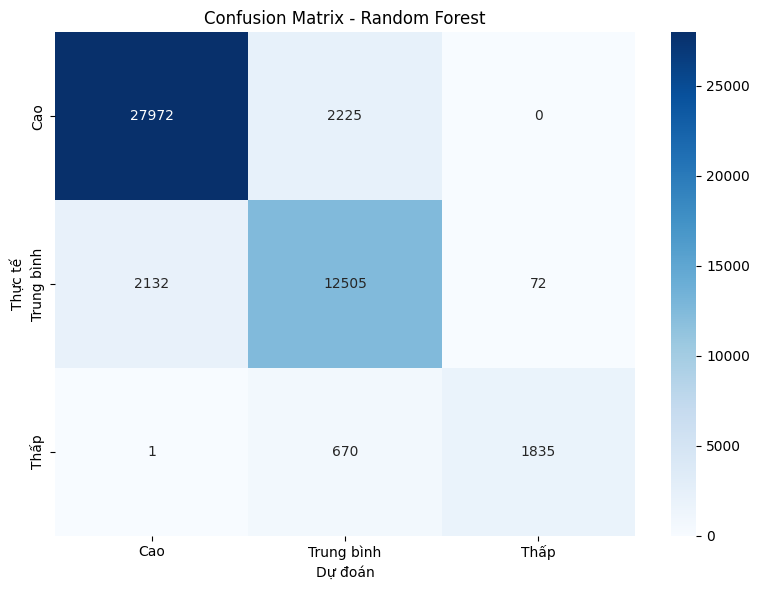


2. BÁO CÁO PHÂN LOẠI CHI TIẾT:
              precision    recall  f1-score   support

         Cao       0.93      0.93      0.93     30197
  Trung bình       0.81      0.85      0.83     14709
        Thấp       0.96      0.73      0.83      2506

    accuracy                           0.89     47412
   macro avg       0.90      0.84      0.86     47412
weighted avg       0.89      0.89      0.89     47412


3. ROC CURVES:


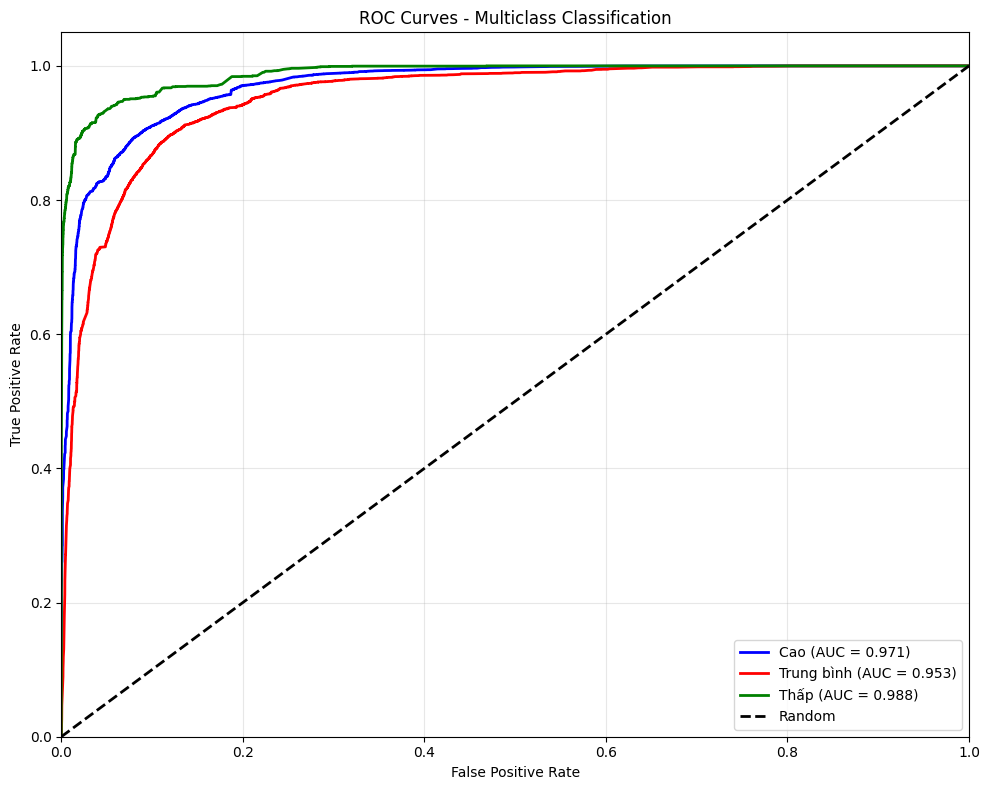


4. MACRO VÀ MICRO AVERAGES:
   Macro-average AUC: 0.9703
   Micro-average AUC: 0.9779

5. THỐNG KÊ CONFUSION MATRIX:
   Ma trận nhầm lẫn:
   [Cao]     [Trung bình] [Thấp]
   Cao: [27972  2225     0]
   Trung bình: [ 2132 12505    72]
   Thấp: [   1  670 1835]

   Tổng số mẫu: 47412
   Dự đoán đúng: 42312
   Độ chính xác: 0.8924

   Cao:
     Precision: 0.9291
     Recall: 0.9263
     F1-Score: 0.9277

   Trung bình:
     Precision: 0.8120
     Recall: 0.8502
     F1-Score: 0.8306

   Thấp:
     Precision: 0.9622
     Recall: 0.7322
     F1-Score: 0.8316


In [23]:
# ==================== ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST ====================

print("\n" + "="*80)
print("ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST")
print("="*80)

# Đánh giá Random Forest với confusion matrix và AUC
rf_cm, rf_roc_auc = detailed_model_evaluation(rf_predictions, "Random Forest")

# Hiển thị thống kê confusion matrix
print("\n5. THỐNG KÊ CONFUSION MATRIX:")
print("   Ma trận nhầm lẫn:")
print("   [Cao]     [Trung bình] [Thấp]")
for i, row in enumerate(rf_cm):
    class_name = ["Cao", "Trung bình", "Thấp"][i]
    print(f"   {class_name}: {row}")

# Tính các chỉ số từ confusion matrix
total_samples = np.sum(rf_cm)
correct_predictions = np.trace(rf_cm)
accuracy = correct_predictions / total_samples

print(f"\n   Tổng số mẫu: {total_samples}")
print(f"   Dự đoán đúng: {correct_predictions}")
print(f"   Độ chính xác: {accuracy:.4f}")

# Precision, Recall, F1 cho từng class
for i, class_name in enumerate(["Cao", "Trung bình", "Thấp"]):
    tp = rf_cm[i, i]
    fp = np.sum(rf_cm[:, i]) - tp
    fn = np.sum(rf_cm[i, :]) - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n   {class_name}:")
    print(f"     Precision: {precision:.4f}")
    print(f"     Recall: {recall:.4f}")
    print(f"     F1-Score: {f1:.4f}")



ĐÁNH GIÁ MÔ HÌNH LOGISTIC REGRESSION

ĐÁNH GIÁ CHI TIẾT: Logistic Regression

1. CONFUSION MATRIX:


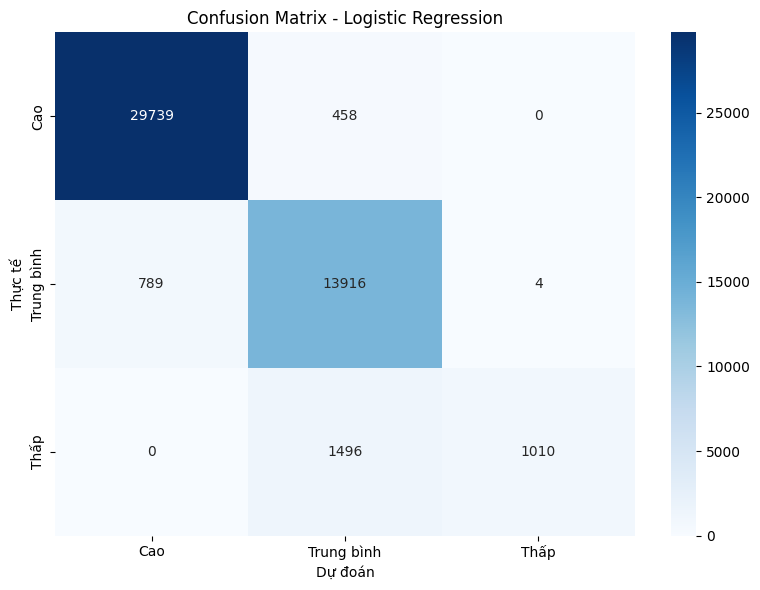


2. BÁO CÁO PHÂN LOẠI CHI TIẾT:
              precision    recall  f1-score   support

         Cao       0.97      0.98      0.98     30197
  Trung bình       0.88      0.95      0.91     14709
        Thấp       1.00      0.40      0.57      2506

    accuracy                           0.94     47412
   macro avg       0.95      0.78      0.82     47412
weighted avg       0.95      0.94      0.94     47412


3. ROC CURVES:


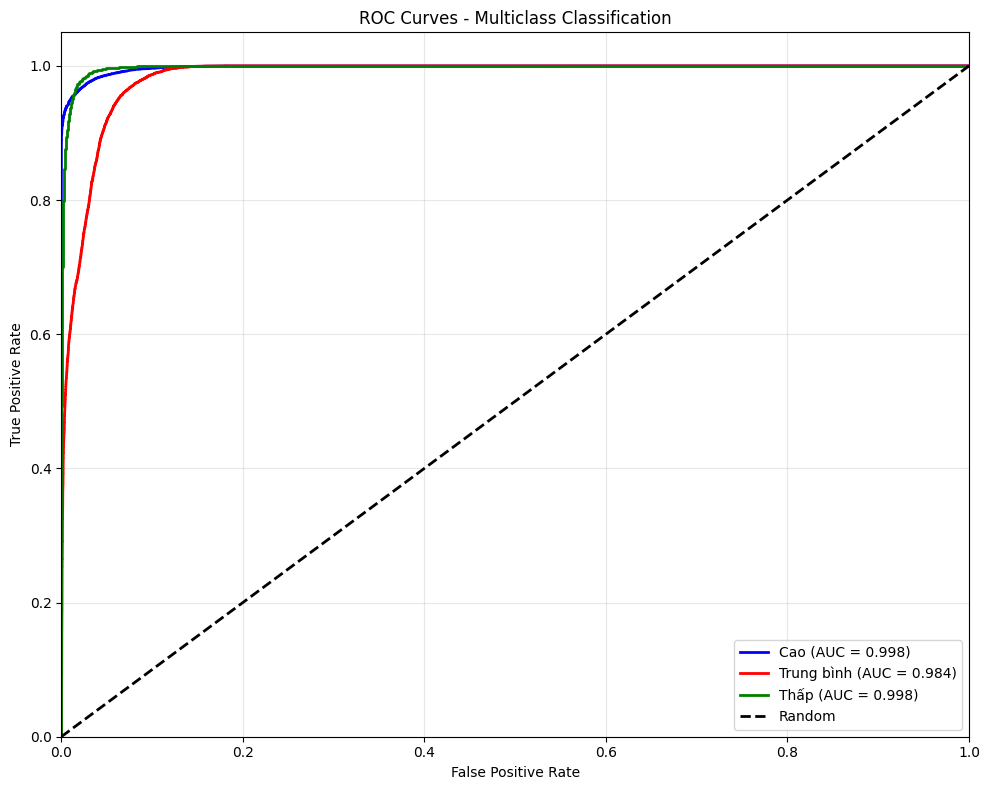


4. MACRO VÀ MICRO AVERAGES:
   Macro-average AUC: 0.9931
   Micro-average AUC: 0.9936

5. THỐNG KÊ CONFUSION MATRIX:
   Ma trận nhầm lẫn:
   [Cao]     [Trung bình] [Thấp]
   Cao: [29739   458     0]
   Trung bình: [  789 13916     4]
   Thấp: [   0 1496 1010]

   Tổng số mẫu: 47412
   Dự đoán đúng: 44665
   Độ chính xác: 0.9421

   Cao:
     Precision: 0.9742
     Recall: 0.9848
     F1-Score: 0.9795

   Trung bình:
     Precision: 0.8769
     Recall: 0.9461
     F1-Score: 0.9102

   Thấp:
     Precision: 0.9961
     Recall: 0.4030
     F1-Score: 0.5739


In [24]:
# ==================== ĐÁNH GIÁ MÔ HÌNH LOGISTIC REGRESSION ====================

print("\n" + "="*80)
print("ĐÁNH GIÁ MÔ HÌNH LOGISTIC REGRESSION")
print("="*80)

# Đánh giá Logistic Regression với confusion matrix và AUC
lr_cm, lr_roc_auc = detailed_model_evaluation(lr_predictions, "Logistic Regression")

# Hiển thị thống kê confusion matrix
print("\n5. THỐNG KÊ CONFUSION MATRIX:")
print("   Ma trận nhầm lẫn:")
print("   [Cao]     [Trung bình] [Thấp]")
for i, row in enumerate(lr_cm):
    class_name = ["Cao", "Trung bình", "Thấp"][i]
    print(f"   {class_name}: {row}")

# Tính các chỉ số từ confusion matrix
total_samples = np.sum(lr_cm)
correct_predictions = np.trace(lr_cm)
accuracy = correct_predictions / total_samples

print(f"\n   Tổng số mẫu: {total_samples}")
print(f"   Dự đoán đúng: {correct_predictions}")
print(f"   Độ chính xác: {accuracy:.4f}")

# Precision, Recall, F1 cho từng class
for i, class_name in enumerate(["Cao", "Trung bình", "Thấp"]):
    tp = lr_cm[i, i]
    fp = np.sum(lr_cm[:, i]) - tp
    fn = np.sum(lr_cm[i, :]) - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n   {class_name}:")
    print(f"     Precision: {precision:.4f}")
    print(f"     Recall: {recall:.4f}")
    print(f"     F1-Score: {f1:.4f}")



SO SÁNH MÔ HÌNH VỚI AUC SCORES

SO SÁNH AUC SCORES:
--------------------------------------------------
Random Forest:
  - Macro-average AUC: 0.9703
  - Cao AUC: 0.9707
  - Trung bình AUC: 0.9526
  - Thấp AUC: 0.9877

Logistic Regression:
  - Macro-average AUC: 0.9931
  - Cao AUC: 0.9977
  - Trung bình AUC: 0.9840
  - Thấp AUC: 0.9975

KẾT LUẬN DỰA TRÊN AUC:
✓ Mô hình tốt nhất theo AUC: Logistic Regression
  Macro-average AUC: 0.9931
  Chênh lệch: 0.0228


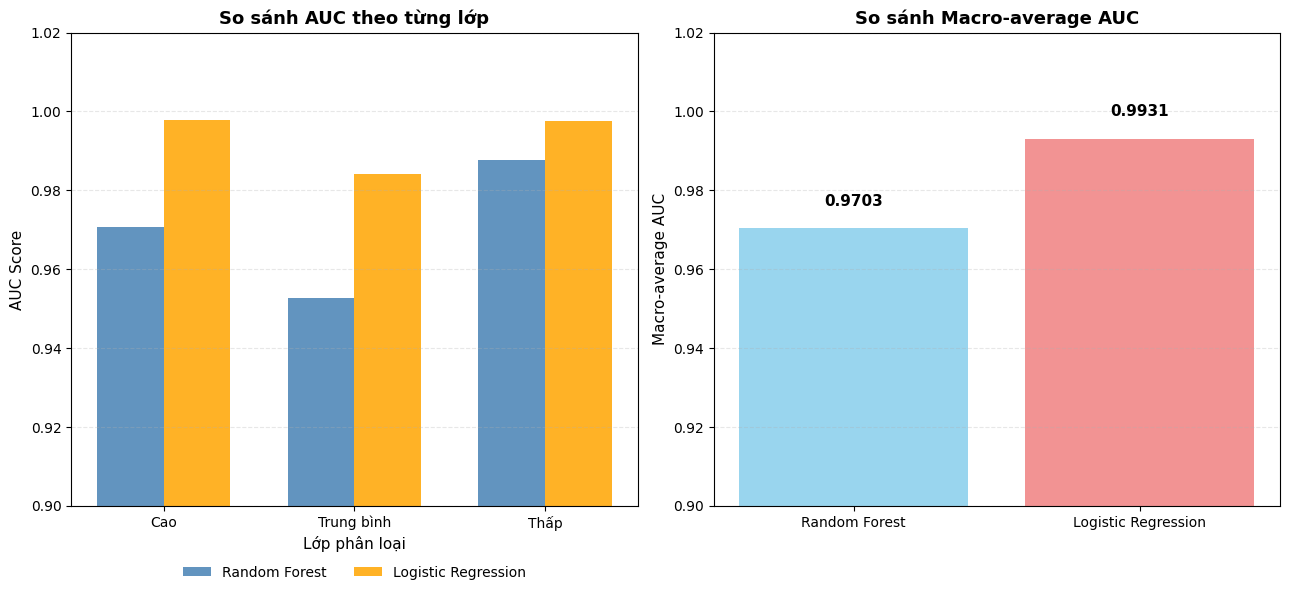


TÓM TẮT ĐÁNH GIÁ:
1. Confusion Matrix: Hiển thị ma trận nhầm lẫn giữa các lớp
2. ROC Curves: Đánh giá khả năng phân biệt của mô hình
3. AUC Scores: Đo lường hiệu suất tổng thể
4. Classification Report: Báo cáo chi tiết precision, recall, f1-score

✓ Các chỉ số này giúp đánh giá toàn diện hiệu suất mô hình phân loại!


In [26]:
# ==================== SO SÁNH MÔ HÌNH VỚI AUC ====================

print("\n" + "="*80)
print("SO SÁNH MÔ HÌNH VỚI AUC SCORES")
print("="*80)

# So sánh AUC scores
print("\nSO SÁNH AUC SCORES:")
print("-" * 50)

# Random Forest AUC
rf_macro_auc = np.mean(list(rf_roc_auc.values()))
print(f"Random Forest:")
print(f"  - Macro-average AUC: {rf_macro_auc:.4f}")
for i, class_name in enumerate(["Cao", "Trung bình", "Thấp"]):
    print(f"  - {class_name} AUC: {rf_roc_auc[i]:.4f}")

print()

# Logistic Regression AUC  
lr_macro_auc = np.mean(list(lr_roc_auc.values()))
print(f"Logistic Regression:")
print(f"  - Macro-average AUC: {lr_macro_auc:.4f}")
for i, class_name in enumerate(["Cao", "Trung bình", "Thấp"]):
    print(f"  - {class_name} AUC: {lr_roc_auc[i]:.4f}")

# Xác định mô hình tốt nhất dựa trên AUC
print(f"\n{'='*50}")
print("KẾT LUẬN DỰA TRÊN AUC:")
print(f"{'='*50}")

if lr_macro_auc > rf_macro_auc:
    best_auc_model = "Logistic Regression"
    best_auc_score = lr_macro_auc
    print(f"✓ Mô hình tốt nhất theo AUC: {best_auc_model}")
    print(f"  Macro-average AUC: {best_auc_score:.4f}")
    print(f"  Chênh lệch: {lr_macro_auc - rf_macro_auc:.4f}")
else:
    best_auc_model = "Random Forest"
    best_auc_score = rf_macro_auc
    print(f"✓ Mô hình tốt nhất theo AUC: {best_auc_model}")
    print(f"  Macro-average AUC: {best_auc_score:.4f}")
    print(f"  Chênh lệch: {rf_macro_auc - lr_macro_auc:.4f}")

# Vẽ biểu đồ so sánh AUC
plt.figure(figsize=(13, 6))

# Subplot 1: So sánh AUC theo class
plt.subplot(1, 2, 1)
classes = ["Cao", "Trung bình", "Thấp"]
rf_aucs = [rf_roc_auc[i] for i in range(3)]
lr_aucs = [lr_roc_auc[i] for i in range(3)]

x = np.arange(len(classes))
width = 0.35

plt.bar(x - width/2, rf_aucs, width, label='Random Forest', alpha=0.85, color='steelblue')
plt.bar(x + width/2, lr_aucs, width, label='Logistic Regression', alpha=0.85, color='orange')

plt.xlabel('Lớp phân loại', fontsize=11)
plt.ylabel('AUC Score', fontsize=11)
plt.title('So sánh AUC theo từng lớp', fontsize=13, weight='bold')
plt.xticks(x, classes)
plt.ylim(0.9, 1.02)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, frameon=False)

# Subplot 2: So sánh Macro-average AUC
plt.subplot(1, 2, 2)
models = ['Random Forest', 'Logistic Regression']
macro_aucs = [rf_macro_auc, lr_macro_auc]
colors = ['skyblue', 'lightcoral']

bars = plt.bar(models, macro_aucs, color=colors, alpha=0.85)
plt.ylabel('Macro-average AUC', fontsize=11)
plt.title('So sánh Macro-average AUC', fontsize=13, weight='bold')
plt.ylim(0.9, 1.02)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Thêm giá trị trên cột
for bar, auc in zip(bars, macro_aucs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{auc:.4f}', ha='center', va='bottom', fontsize=11, weight='bold')

plt.subplots_adjust(wspace=0.35, bottom=0.18)
plt.tight_layout()
plt.show()

print(f"\n{'='*50}")
print("TÓM TẮT ĐÁNH GIÁ:")
print(f"{'='*50}")
print("1. Confusion Matrix: Hiển thị ma trận nhầm lẫn giữa các lớp")
print("2. ROC Curves: Đánh giá khả năng phân biệt của mô hình")
print("3. AUC Scores: Đo lường hiệu suất tổng thể")
print("4. Classification Report: Báo cáo chi tiết precision, recall, f1-score")
print("\n✓ Các chỉ số này giúp đánh giá toàn diện hiệu suất mô hình phân loại!")


In [22]:
from pyspark.sql.functions import udf, col, rand
from pyspark.sql.types import StringType

# Ánh xạ nhãn số sang tên (theo thứ tự StringIndexer đã huấn luyện)
label_mapping = {0.0: "Cao", 1.0: "Trung bình", 2.0: "Thấp"}
map_label_udf = udf(lambda x: label_mapping.get(x, "Không rõ"), StringType())

# Lấy 10 mẫu ngẫu nhiên từ tập test
sample_test = test_data.orderBy(rand()).limit(10)

# Xác định mô hình tốt nhất
if best_model["name"] == "Random Forest":
    best_model_object = best_rf_model
elif best_model["name"] == "Logistic Regression":
    best_model_object = best_lr_model
else:
    raise ValueError("Không xác định được mô hình tốt nhất!")

# Dự đoán
sample_predictions = best_model_object.transform(sample_test)

# Thêm nhãn thật và dự đoán dạng chữ
sample_with_labels = (
    sample_predictions
    .withColumn("Phân_Loại", map_label_udf(col("prediction")))
)

# Hiển thị các cột chính
columns_to_show = [
    "city1", "city2", "passengers", "fare", "nsmiles",
    "large_ms", "lf_ms", "fare_lg", "fare_low","Phân_Loại"
]

print(f"\n Dự đoán 10 mẫu ngẫu nhiên bằng mô hình tốt nhất: {best_model['name']}")
sample_with_labels.select(columns_to_show).show(truncate=False)



 Dự đoán 10 mẫu ngẫu nhiên bằng mô hình tốt nhất: Logistic Regression
+-------------------------------------+-------------------------------------+----------+------+-------+--------+------+-------+--------+----------+
|city1                                |city2                                |passengers|fare  |nsmiles|large_ms|lf_ms |fare_lg|fare_low|Phân_Loại |
+-------------------------------------+-------------------------------------+----------+------+-------+--------+------+-------+--------+----------+
|Chicago, IL                          |Portland, ME                         |141       |340.41|900    |0.6     |0.29  |398.02 |245.22  |Cao       |
|Buffalo, NY                          |New York City, NY (Metropolitan Area)|271       |105.92|326    |0.98    |0.98  |105.42 |105.42  |Trung bình|
|New York City, NY (Metropolitan Area)|St. Louis, MO                        |478       |291.42|928    |0.81    |0.01  |303.0  |163.91  |Cao       |
|Houston, TX                          |Me